**Business questions formulation:**

1. How looks the typical guest using AirBnB services? Is it foreigner or countryman? What is typical age?
2. When the most people visit each city?
3. What are the average prices per night?
4. What is average realized revenue per month?
5. In which month is the most profitable to be landlord? In which month is best to do reconstructions?
6. In which month is the most cost effective to visit the city as guest?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
import datetime
%matplotlib inline
import gender_guesser.detector as gender

**Gathering necessary data**

Based on my personal interrest the following cities were selected:
- Prague
- Munich
- ~~Zurich~~ (Zurich data were not accessible during completition of this project)
- Geneva 
- San Francisco

To answer the questions above I've choosen [Data Published on InsideAirBnB](http://insideairbnb.com/get-the-data.html)

**Assessing the data**

To exclude differences caused by variety in listing only the following accomodations will be considered:
       - 2 guests, apartment, entire room, 1x bedroom, 1xbed, 1x private bath
       
To answer the question one the following data from ***listings.csv*** will be used:
    - 'id'
    - 'price'
    - 'host_response_time'
    
To answer the question two and three the following data from ***calendar.csv*** will be used:
    - 'listing_id'
    - 'date'
    - 'price'
    - 'avaibility'

In [34]:
class City:
    data_selection_done = False # Indicate whether redundant columns were already removed
    data_cleaning_done = False # Indicate whether data were already cleaned
    
    monthly_avaibility = None # monthly average of properties avaibility
    monthly_price = None # monthly average of rental prices
    monthly_price_min = None
    monthly_price_max = None
    monthly_avaibility_min = None
    monthly_avaibility_max = None
    
    data_timeframe = None # Range of dataset (e.g. "2019 November - 2020 December")


    
    def __init__(self, name, data_folder):
        self.name = name
        self.data_folder = data_folder
        
        self.listings = pd.read_csv(self.data_folder + "/listings.csv")
        self.calendar = pd.read_csv(self.data_folder + "/calendar.csv")
        self.reviews = None
        
    def load_reviews(self):
        self.reviews = pd.read_csv(self.data_folder + "/reviews.csv")

In [35]:
#Initialize cities
prague = City("Prague", "../Dataset/Prague")
munich = City("Munich", "../Dataset/Munich")
san_francisco = City("San Francisco", "../Dataset/San Francisco")
geneva = City("Geneva", "../Dataset/Geneva")

cities_list = [prague, munich, san_francisco, geneva]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: DtypeWarning: Columns (95) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: DtypeWarning: Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2901: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [36]:
def get_rows_cols(df):
    '''
        Print number of rows and columns in a provided dataset
        
        Parameters:
        arg1 (pandas_dataframe): Dataframe for which number of rows and columns is printed
        
        Returns:
        Nothing
    '''
    
    rows = df.shape[0] #Provide the number of rows in the dataset
    cols = df.shape[1] #Provide the number of columns in the dataset
    
    return rows, cols

def explore_data(city):
    ''' Prints basic info about the dataset
        
        Parameters:
        Nothing
        
        Returns:
        Nothing
    '''
    
    print("\n= Data exploration for city {0} =".format(city.name))
    
    rows, cols = get_rows_cols(city.listings)
    print ("The dataset \'listings\' has: {0} rows and {1} columns".format(rows, cols))
    print(" - Columns: {0}".format(city.listings.columns.values))
    
    rows, cols = get_rows_cols(city.calendar)
    print ("The dataset \'calendar\' has: {0} rows and {1} columns".format(rows, cols))
    print(" - Columns: {0}".format(city.calendar.columns.values))


print(" === Data exploration of innitial datasets ===")
for city in cities_list:
    explore_data(city)

 === Data exploration of innitial datasets ===

= Data exploration for city Prague =
The dataset 'listings' has: 14184 rows and 106 columns
 - Columns: ['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'access' 'interaction' 'house_rules' 'thumbnail_url'
 'medium_url' 'picture_url' 'xl_picture_url' 'host_id' 'host_url'
 'host_name' 'host_since' 'host_location' 'host_about'
 'host_response_time' 'host_response_rate' 'host_acceptance_rate'
 'host_is_superhost' 'host_thumbnail_url' 'host_picture_url'
 'host_neighbourhood' 'host_listings_count' 'host_total_listings_count'
 'host_verifications' 'host_has_profile_pic' 'host_identity_verified'
 'street' 'neighbourhood' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'city' 'state' 'zipcode' 'market'
 'smart_location' 'country_code' 'country' 'latitude' 'longitude'
 'is_location_exact' 'property_type' 'room_type' 'accommodates'
 'bath

In [37]:
def select_relevant_data(city):
    ''' Selects relevant data from the whole dataset
        
        Parameters:
            - city as object City with loaded data for a given city
        
        Returns:
        Nothing
    '''
    
    if city.data_selection_done == True: # Avoid removing columns that were already removed
        print("City \'{0}\': Relevant columns were already removed".format(city.name))
        return
    
    print("= Data selection for city {0} =".format(city.name))

    # Selection of listing fulfilling condition for 2 guests, apartment, entire room, 1x bedroom, 1xbed, 1x private bath
    city.listings = city.listings[(city.listings['property_type'] == 'Apartment') & (city.listings['room_type'] == 'Entire home/apt') & (city.listings['accommodates'] > 2) & (city.listings['bathrooms'] == 1) & (city.listings['bathrooms'] == 1) & (city.listings['bedrooms'] == 1)]
    print_rows_cols(city.listings)

    # Keep in the calendar dataset only properties fulfilling the conditions above
    city.calendar = city.calendar[(city.calendar['listing_id'].isin(city.listings['id']))]
    print_rows_cols(city.calendar)

    # Only relevant columns are further processed
    city.listings = city.listings[['id', 'price', 'host_response_time']].copy()
    
    city.data_selection_done = True

for city in cities_list:
    select_relevant_data(city)

= Data selection for city Prague =
The dataset has: 2722 rows and 106 columns
The dataset has: 993532 rows and 7 columns
= Data selection for city Munich =
The dataset has: 1360 rows and 106 columns
The dataset has: 496400 rows and 7 columns
= Data selection for city San Francisco =
The dataset has: 355 rows and 106 columns
The dataset has: 129218 rows and 7 columns
= Data selection for city Geneva =
The dataset has: 327 rows and 106 columns
The dataset has: 119355 rows and 7 columns


In [38]:
print(" === Data exploration after the selection ===")
for city in cities_list:
    explore_data(city)

 === Data exploration after the selection ===

= Data exploration for city Prague =
The dataset 'listings' has: 2722 rows and 3 columns
 - Columns: ['id' 'price' 'host_response_time']
The dataset 'calendar' has: 993532 rows and 7 columns
 - Columns: ['listing_id' 'date' 'available' 'price' 'adjusted_price' 'minimum_nights'
 'maximum_nights']

= Data exploration for city Munich =
The dataset 'listings' has: 1360 rows and 3 columns
 - Columns: ['id' 'price' 'host_response_time']
The dataset 'calendar' has: 496400 rows and 7 columns
 - Columns: ['listing_id' 'date' 'available' 'price' 'adjusted_price' 'minimum_nights'
 'maximum_nights']

= Data exploration for city San Francisco =
The dataset 'listings' has: 355 rows and 3 columns
 - Columns: ['id' 'price' 'host_response_time']
The dataset 'calendar' has: 129218 rows and 7 columns
 - Columns: ['listing_id' 'date' 'available' 'price' 'adjusted_price' 'minimum_nights'
 'maximum_nights']

= Data exploration for city Geneva =
The dataset 'lis

In [39]:
def clean_data(city):

    if city.data_cleaning_done == True: # Avoid double cleaning
        print("City \'{0}\': Relevant columns were already cleaned".format(city.name))
        return
    
    print("\n= Data cleaning for city {0} =".format(city.name))

    
    # === 1. Cleaning of 'listings.csv' dataset

    #Check if there are missing values in any of the rows or columns
    no_nulls = set(city.listings.columns[city.listings.isnull().mean()==0]) #Provide a set of columns with 0 missing values.
    print (no_nulls)
    # => nulls contains only column 'host_response_time'

    prop_response_time = 1 - city.listings.isnull()['host_response_time'].mean()# Proportion of individuals in the dataset with salary reported
    print ("host_response_time has: %f%% of not null values"%(prop_response_time))

    # To handle missing values in column 'host_response_time' we will drop them and use remaining ~90% of data where we have values.
    # As we explore relationship between columns 'host_response_time' and 'price' - rows with missing values are not useful for our analysis and imputing them would skew our results
    city.listings = city.listings.dropna(subset=['host_response_time'])
    print_rows_cols(city.listings)

    #Check if any columns are of different data types than you would expect (ex: numbers showing as strings)

    #Convert prices (stored as string '$80.00') to integer so we can work with it
    print ("Unique values in 'host_response_time':")
    print (city.listings['host_response_time'].unique())
    print (city.listings.dtypes)

    city.listings['price'] = city.listings.price.str.replace('$', '')
    city.listings['price'] = city.listings.price.str.replace(',', '')
    city.listings['price'] = city.listings.price.astype(float)

    # === 2. Cleaning of 'calendar.csv' dataset
    #drop column 'listing_id' as we need to generate monthly average only for columns 'price' and 'available'
    city.calendar = city.calendar.drop(columns=["listing_id"])


    # Label encoding (transferring True/False into 1/0) so we can easily generate statistics for 'available'
    city.calendar["available"] = city.calendar["available"].astype('category')
    city.calendar["available"] = city.calendar["available"].cat.codes

    #Convert prices data into format that can be converted into number ('$1,100.00' => '1100.00')
    city.calendar['price'] = city.calendar.price.str.replace('$', '')
    city.calendar['price'] = city.calendar.price.str.replace(',', '').astype(float)

    #Index date so prices can be in the next step grouped into monthly averages
    city.calendar['date'] = pd.to_datetime(city.calendar['date'])
    city.calendar = city.calendar.set_index('date')
    
    city.data_cleaning_done = True

for city in cities_list:
    clean_data(city)    


= Data cleaning for city Prague =
{'price', 'id'}
host_response_time has: 0.850478% of not null values
The dataset has: 2315 rows and 3 columns
Unique values in 'host_response_time':
['within an hour' 'within a few hours' 'within a day' 'a few days or more']
id                     int64
price                 object
host_response_time    object
dtype: object

= Data cleaning for city Munich =
{'price', 'id'}
host_response_time has: 0.556618% of not null values
The dataset has: 757 rows and 3 columns
Unique values in 'host_response_time':
['within an hour' 'within a few hours' 'within a day' 'a few days or more']
id                     int64
price                 object
host_response_time    object
dtype: object

= Data cleaning for city San Francisco =
{'price', 'id'}
host_response_time has: 0.870423% of not null values
The dataset has: 309 rows and 3 columns
Unique values in 'host_response_time':
['within a day' 'within a few hours' 'within an hour' 'a few days or more']
id           

In [40]:
print(" === Data exploration after the cleaning ===")
for city in cities_list:
    explore_data(city)

 === Data exploration after the cleaning ===

= Data exploration for city Prague =
The dataset 'listings' has: 2315 rows and 3 columns
 - Columns: ['id' 'price' 'host_response_time']
The dataset 'calendar' has: 993532 rows and 5 columns
 - Columns: ['available' 'price' 'adjusted_price' 'minimum_nights' 'maximum_nights']

= Data exploration for city Munich =
The dataset 'listings' has: 757 rows and 3 columns
 - Columns: ['id' 'price' 'host_response_time']
The dataset 'calendar' has: 496400 rows and 5 columns
 - Columns: ['available' 'price' 'adjusted_price' 'minimum_nights' 'maximum_nights']

= Data exploration for city San Francisco =
The dataset 'listings' has: 309 rows and 3 columns
 - Columns: ['id' 'price' 'host_response_time']
The dataset 'calendar' has: 129218 rows and 5 columns
 - Columns: ['available' 'price' 'adjusted_price' 'minimum_nights' 'maximum_nights']

= Data exploration for city Geneva =
The dataset 'listings' has: 200 rows and 3 columns
 - Columns: ['id' 'price' 'hos

In [41]:
def analyze_data(city):
    # === 1. Analysis of 'listings.csv' dataset
    
    print("\n= Data analysis for city {0} =".format(city.name))

    # Analyze Dataset Range (e.g. "2019 November - 2020 December")
    year_min = city.calendar.index.min().strftime('%Y %B')
    year_max = city.calendar.index.max().strftime('%Y %B')
    city.data_timeframe = "{0} - {1}".format(year_min, year_max)
    print (city.data_timeframe)
    
    # === 2. Analysis of 'calendar.csv' dataset

    #resampling daily property avaibility into its monthly average
    city.monthly_avaibility = city.calendar.resample('M').agg({'available': 'mean'})

    # = Analyze monthly avaibility
    #Get min and max avaibility
    city.monthly_avaibility_max = city.monthly_avaibility.loc[city.monthly_avaibility.idxmax()]
    city.monthly_avaibility_min = city.monthly_avaibility.loc[city.monthly_avaibility.idxmin()]

    print("\nAvaibility max: {}".format(city.monthly_avaibility_max))
    print("Avaibility min: {}".format(city.monthly_avaibility_min))

    # = Analyze monthly prices

    # To handle missing values in column 'price' we will drop them.
    # As we are interrested in generating average monthly prices, rows with missing price values are not useful for our analysis and imputing them would skew our results
    city.monthly_price = city.calendar.dropna(subset=['price']) #Remove N/A values

    city.monthly_price = city.calendar.resample('M').agg({'price': 'mean'})

    #Get min and max price
    city.monthly_price_max = city.monthly_price.loc[city.monthly_price.idxmax()]
    city.monthly_price_min = city.monthly_price.loc[city.monthly_price.idxmin()]

    print("\nPrice max: {0}".format(city.monthly_price_max))
    print("Price min: {0}".format(city.monthly_price_min))

for city in cities_list:
    print(" === Data analysis ===")
    analyze_data(city)

 === Data analysis ===

= Data analysis for city Prague =
2019 November - 2020 December

Avaibility max:             available
date                 
2020-02-29   0.623793
Avaibility min:             available
date                 
2019-11-30   0.059946

Price max:                   price
date                   
2020-10-31  2999.853227
Price min:               price
date               
2020-12-31  1498.84
 === Data analysis ===

= Data analysis for city Munich =
2019 November - 2020 December

Avaibility max:             available
date                 
2020-02-29   0.237272
Avaibility min:             available
date                 
2020-12-31        0.0

Price max:                 price
date                 
2020-09-30  152.20125
Price min:             price
date             
2020-12-31   81.2
 === Data analysis ===

= Data analysis for city San Francisco =
2019 December - 2020 December

Avaibility max:             available
date                 
2020-02-29   0.623125
Avaibility min:   

Object `age` not found.


**===Answer to Question 1===**
1. How looks the typical guest using AirBnB services? Is it foreigner or countryman? What is typical age?

Here I intended to use unsupervised machine learning to identify guests segments as I did in [this project](https://github.com/JMarcan/unsupervised_learning_customer_segments). However, the only data available about guests seems to be their name in 'reviews.csv'. 

Therefore, the only thing we can find out is whether guests writing reviews are in majority men or women. 

When singer from my hometown Jaromir Nohavica openened his cabaret club, he mentioned that "The secret is to make this place nice for women. When the place is nice for women, they will brings men with them.". Let's check whether its applicable even here.

As training my machine learning model for this task would be an overkill,
I decided to use avaible python library [gender_guesser](https://pypi.org/project/gender-guesser/) that can predict whether a provided name is male or female.

**Steps to get answer to the question 1**

In [42]:
def explore_reviews_dataset(city):
    print("\n= Explore dataset for city {0} =".format(city.name))

    city.load_reviews()
    print(city.reviews.columns.values)
    
for city in cities_list:
    print(" === Explore reviews dataset ===")
    explore_reviews_dataset(city)

 === Explore reviews dataset ===

= Explore dataset for city Prague =
['listing_id' 'id' 'date' 'reviewer_id' 'reviewer_name' 'comments']
 === Explore reviews dataset ===

= Explore dataset for city Munich =
['listing_id' 'id' 'date' 'reviewer_id' 'reviewer_name' 'comments']
 === Explore reviews dataset ===

= Explore dataset for city San Francisco =
['listing_id' 'id' 'date' 'reviewer_id' 'reviewer_name' 'comments']
 === Explore reviews dataset ===

= Explore dataset for city Geneva =
['listing_id' 'id' 'date' 'reviewer_id' 'reviewer_name' 'comments']


In [43]:
d = gender.Detector()

def get_statistics_row(city):
    
    print("\n= Get statistics row for city {0} =".format(city.name))

    city.reviews['gender'] = city.reviews['reviewer_name'].map(lambda x: d.get_gender(x))

    total_count = city.reviews['gender'].shape[0]
    males_count= (city.reviews['gender'] == 'male').sum()
    females_count = (city.reviews['gender'] == 'female').sum()
    unknown_count =  total_count - (males_count + females_count)

    males_perc = (100*males_count/total_count)
    females_perc = (100*females_count/total_count)
    unknown_perc = (100*unknown_count/total_count)

    df1 = pd.DataFrame({'city': [city.name], 
                    'male_%': [males_perc],
                    'female_%': [females_perc],
                    'unknown_%': [unknown_perc],
                    'count_of_records': [total_count]
                   })
    return df1

table_gender = pd.DataFrame(columns = ['city', 'male_%', 'female_%', 'unknown_%', 'count_of_records'])

for city in cities_list:
    df1 = get_statistics_row(city)
    table_gender = table_gender.append(df1)

display(table_gender)


= Get statistics row for city Prague =

= Get statistics row for city Munich =

= Get statistics row for city San Francisco =

= Get statistics row for city Geneva =


,city,male_%,female_%,unknown_%,count_of_records
0,Prague,38.165244,37.377830,24.456925,683884
0,Munich,41.412720,35.314590,23.272690,175562
0,San Francisco,38.868420,37.892379,23.239201,382156
0,Geneva,38.629462,36.549154,24.821384,68163


You can see that the library identified in each city gender for more than 75% of inputs.

The table does not show significant difference between ratio of males and females writing reviews.
Maximum deviation of 6% has Munich where 41% of authors were identified as males and 35% as females. Taking into consideration unknown gender for authors of 23% reviews for Munich, we will assume that ratio is close to 50:50 as is case for other cities.

Seems the Wisdom "The secret is to make this place nice for women." is not applicable here. If host wants to have good reviews, he needs to take care about both genders equaly. Which he should do anyway.

**Answer to Question 5 & 6**
- Question 5. In which month is the most profitable to be landlord? In which month is best to do reconstructions?
- Question 6. In which month is the most cost effective to visit the city as guest?

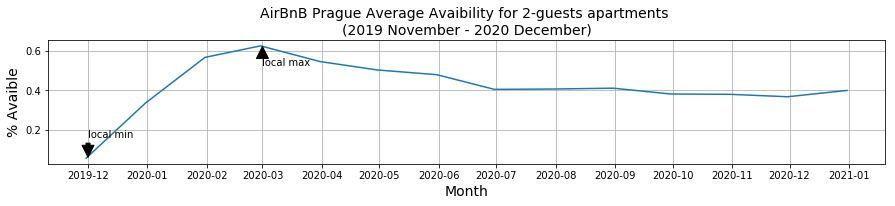

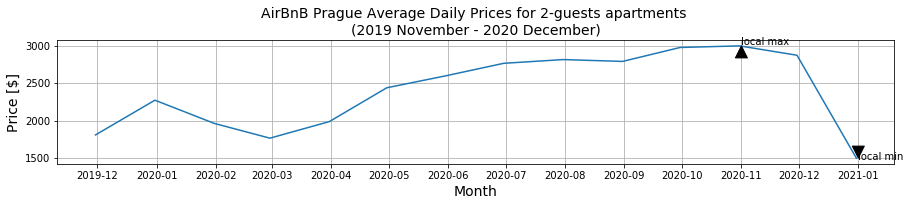

In [123]:
def visualize_monthly_price(city):

    plt.figure(figsize=(15, 5))
    ax = plt.subplot(211)
    plt.plot(city.monthly_avaibility['available'])
    plt.title('AirBnB {0} Average Avaibility for 2-guests apartments \n({1})'.format(city.name, city.data_timeframe), fontsize=14)
    plt.ylabel('% Avaible', fontsize=14)
    plt.xlabel('Month', fontsize=14)
    plt.grid(True)

    months = mdates.MonthLocator()
    dfmt = dates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(dfmt)
    
    ax.annotate('local max', xy=(city.monthly_avaibility_max.index[0]+datetime.timedelta(days=1), city.monthly_avaibility_max.iloc[0][0]), xytext=(city.monthly_avaibility_max.index[0]+datetime.timedelta(days=1), city.monthly_avaibility_max.iloc[0][0]-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
    ax.annotate('local min', xy=(city.monthly_avaibility_min.index[0]+datetime.timedelta(days=1), city.monthly_avaibility_min.iloc[0][0]), xytext=(city.monthly_avaibility_min.index[0]+datetime.timedelta(days=1), city.monthly_avaibility_min.iloc[0][0]+0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
    
    
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(212)
    plt.plot(city.monthly_price['price'])
    plt.title('AirBnB {0} Average Daily Prices for 2-guests apartments \n({1})'.format(city.name, city.data_timeframe), fontsize=14)
    plt.ylabel('Price [$]', fontsize=14)
    plt.xlabel('Month', fontsize=14)
    plt.grid(True)


    months = mdates.MonthLocator()
    dfmt = dates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(dfmt)

    ax.annotate('local max', xy=(city.monthly_price_max.index[0]+datetime.timedelta(days=1), city.monthly_price_max.iloc[0][0]), xytext=(city.monthly_price_max.index[0]+datetime.timedelta(days=1), city.monthly_price_max.iloc[0][0]+20.0),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
    
    ax.annotate('local min', xy=(city.monthly_price_min.index[0]+datetime.timedelta(days=1), city.monthly_price_min.iloc[0][0]), xytext=(city.monthly_price_min.index[0]+datetime.timedelta(days=1), city.monthly_price_min.iloc[0][0]-20.0),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

    plt.show()
    
visualize_monthly_price(prague)    

The figure above shows us that the most profitable time for landlords (and the most expensive one for tenats) was winter month leading with November. In contrast, after the new year are average prices the lowest.